# EXPLORATION_08

### 인물 사진을 만들어 보자

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 사진 준비하기

In [37]:
img_path_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/근접.PNG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_1 = cv2.imread(img_path_1) 
print (img_orig_1.shape)

(822, 820, 3)


## 2. 시맨틱 세그멘테이션 다뤄보기

### 1)   DeepLab 모델 준비

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

### 2) 사전에 학습된 가중치(pretrained weight)를 불러오기

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


### 3)  준비한 이미지를 네트워크에 입력하기

In [38]:
img_resized, seg_map = MODEL.run(img_orig_1)
print (img_orig_1.shape, img_resized.shape, seg_map.max())

(822, 820, 3) (513, 511, 3) 15


### + 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었다. 제공하는 라벨 종류는 아래와 같다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

* seg_map.max() 15의 의미는 여기선'person'이 된다.

### 4) 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶다. =>  마스크를 만들고 시각화해보기

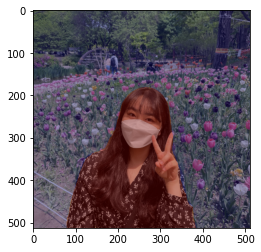

In [39]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 세그멘테이션 결과를 원래 크기로 복원하기

* DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

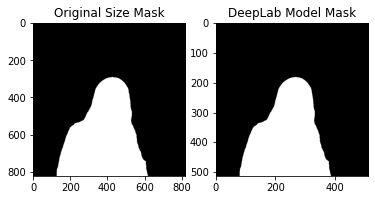

In [40]:
img_mask_up = cv2.resize(img_mask, img_orig_1.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

## 4. 배경 흐리게 하기

* blur() 함수를 이용하여 배경을 흐리게 만들기

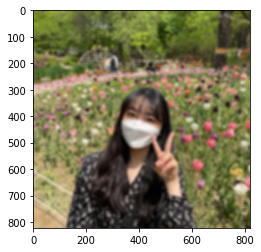

In [41]:
img_orig_blur = cv2.blur(img_orig_1, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

* 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

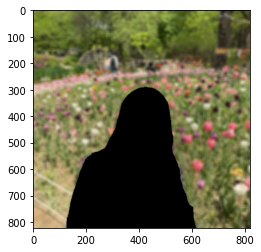

In [42]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 흐린 배경과 원본 영상 합성

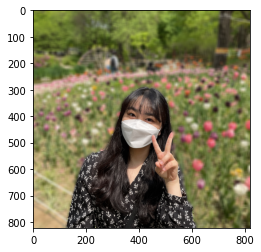

In [43]:
img_concat = np.where(img_mask_color==255, img_orig_1, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 배경사진 바꾸기

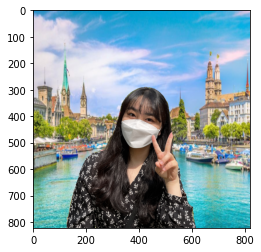

In [45]:
img_resized = cv2.resize(bg2_img_orig, (img_orig_1.shape[1], img_orig_1.shape[0]))

img_mask_resized = cv2.resize(img_mask_color, (img_orig_1.shape[1], img_orig_1.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_orig_1, img_resized)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 🖼 다른 사진 준비하기

### 중간거리 사진

In [13]:
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/보통.PNG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_2 = cv2.imread(img_path_2) 
print (img_orig_2.shape)

(834, 1113, 3)


### 연예인 사진

In [14]:
img_path_3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/joy.PNG'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig_3 = cv2.imread(img_path_3) 
print (img_orig_3.shape)

(689, 569, 3)


### 고양이 

In [15]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.PNG'
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(608, 903, 3)


### 뒷배경1

In [16]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/코코.PNG'
bg_img_orig = cv2.imread(bg_img_path) 
print (bg_img_orig.shape)

(649, 1187, 3)


### 뒷배경2

In [17]:
bg2_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/취리히.PNG'
bg2_img_orig = cv2.imread(bg2_img_path) 
print (bg2_img_orig.shape)

(487, 737, 3)


## 1. 중간거리 사진

In [46]:
img_resized, seg_map = MODEL.run(img_orig_2)
print (img_orig_2.shape, img_resized.shape, seg_map.max())

(834, 1113, 3) (384, 513, 3) 15


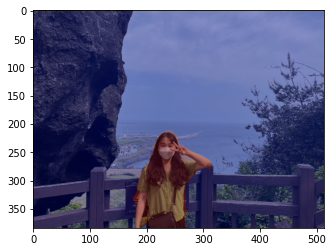

In [47]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

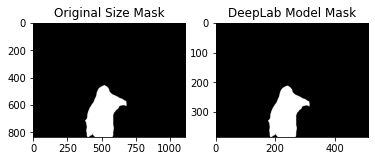

In [48]:
img_mask_up = cv2.resize(img_mask, img_orig_2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

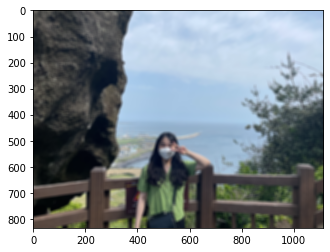

In [49]:
img_orig_blur = cv2.blur(img_orig_2, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

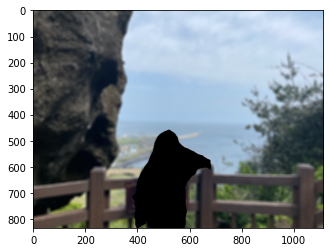

In [50]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

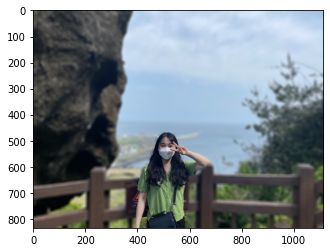

In [51]:
img_concat = np.where(img_mask_color==255, img_orig_2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 바꾸기

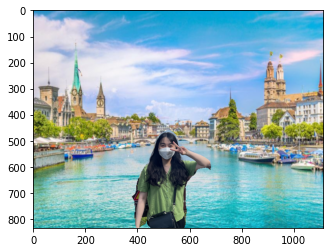

In [52]:
img_resized = cv2.resize(bg2_img_orig, (img_orig_2.shape[1], img_orig_2.shape[0]))

img_mask_resized = cv2.resize(img_mask_color, (img_orig_2.shape[1], img_orig_2.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_orig_2, img_resized)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 연예인 사진

In [53]:
img_resized, seg_map = MODEL.run(img_orig_3)
print (img_orig_3.shape, img_resized.shape, seg_map.max())

(689, 569, 3) (513, 423, 3) 16


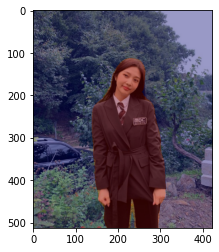

In [54]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

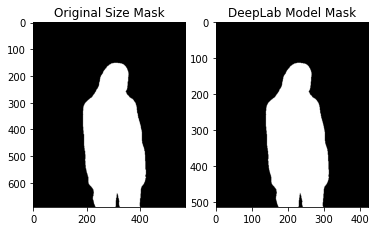

In [55]:
img_mask_up = cv2.resize(img_mask, img_orig_3.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

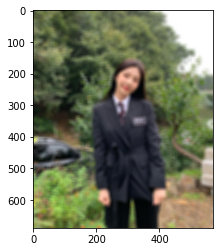

In [56]:
img_orig_blur = cv2.blur(img_orig_3, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

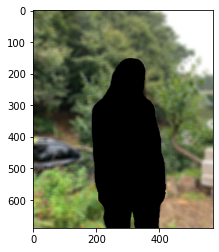

In [57]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

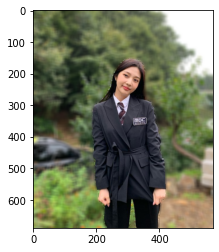

In [58]:
img_concat = np.where(img_mask_color==255, img_orig_3, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 바꾸기

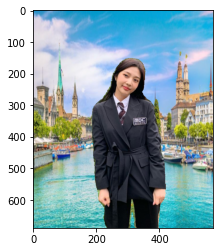

In [59]:
img_resized = cv2.resize(bg2_img_orig, (img_orig_3.shape[1], img_orig_3.shape[0]))

img_mask_resized = cv2.resize(img_mask_color, (img_orig_3.shape[1], img_orig_3.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, img_orig_3, img_resized)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 3. 고양이사진

In [28]:
img_resized, seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, img_resized.shape, seg_map.max())

(608, 903, 3) (345, 513, 3) 8


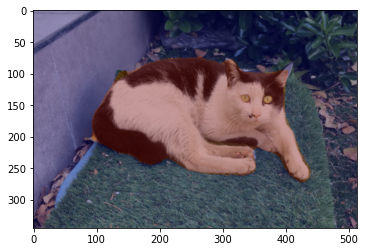

In [29]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

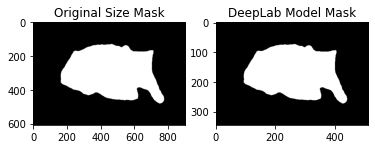

In [30]:
img_mask_up = cv2.resize(img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

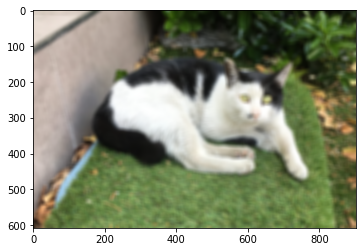

In [31]:
img_orig_blur = cv2.blur(cat_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

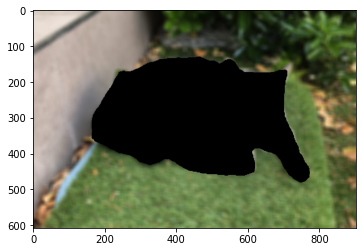

In [32]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

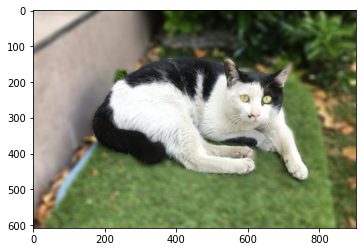

In [33]:
img_concat = np.where(img_mask_color==255, cat_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경 바꾸기

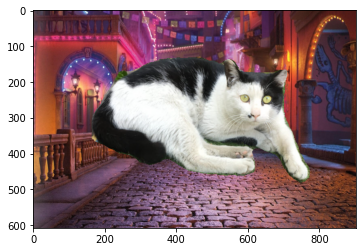

In [35]:
img_resized = cv2.resize(bg_img_orig, (cat_img_orig.shape[1], cat_img_orig.shape[0]))

img_mask_resized = cv2.resize(img_mask_color, (cat_img_orig.shape[1], cat_img_orig.shape[0]))

img_background_concat = np.where(
    img_mask_resized == 255, cat_img_orig, img_resized)

plt.imshow(cv2.cvtColor(img_background_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 인물모드 사진에서 나타나는 문제점

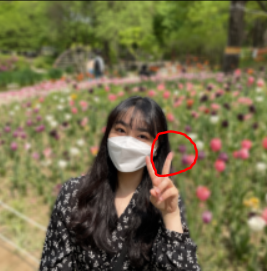

* 손가락 일부분이 인물 영역에 포함되지 않아 blur 처리가 되었다.

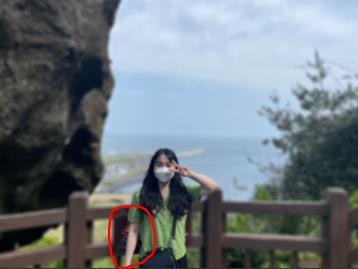 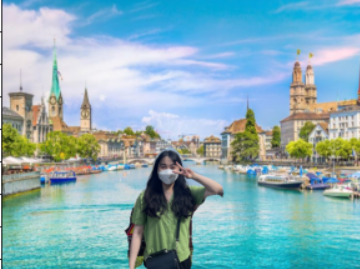

* 팔 뒤에 표지판 부분도 인물영역에 포함되어 blur처리가 되지 않았다.

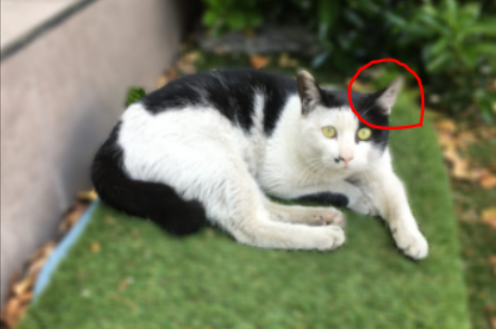

* 고양이 귀의 일부분이 blur 처리 되었다.

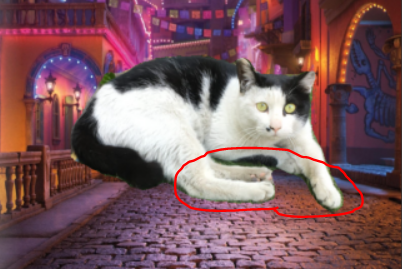

* 고양이와 배경사진 합성 사진을 보면 경계부분이 깔끔하지 못하고 기존의 초록색 영역이 남아있는 것을 볼 수 있다.

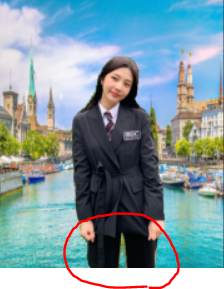

* 이 사진 역시 경계부분이 깔끔하지 못하여 기존 사진의 초록색이 남아있다.

## 인물모드 사진의 문제점을 개선할 수 있는 솔루션 제시

* 논문  A Study on the Improvement of Segmentation Performance using Modified WASPP - Jong-Sik Kim, Dae-Seong Kan

* 시멘틱 세그멘테이션의 성능을 높이기 위한 방법 중 하나로, Spatial pyramid pooling 기법이 많이 활용되고 있는 추세
* 대표적인 알고리즘
    + DeepLab 시리즈의 ASPP(Atrous Spatial Pyramid Pooling) 기법 :특징맵으로 부터 여러 개의 rate가 다른 Atrous 컨볼류션(Convolution)을 병렬로 적용한 뒤, 이를 다시 연결(Concatenate) 하는 방식
<br>



* ASPP의 단점 :  중요한 특징점을 잘 활용하지 못하고 무작위적 특징점 추출 <br>
=> 제안된 웨이버릿 (Wavelet) pooling 방식을 활용하면 다양한 특징점들의 평균을 활용하여 Spatial pyramid pooling 기법의 활용 폭을 확대할 수 있다.


* 구현 방법 : 기존 ASPP는 특정레이어 대해서 Atrous 컨볼류션을 여러 Rate로 진행한 후 결과들을 합치는 구조이다. 여기서 핵심은 Rate 6, 12, 18에서 추출된 특징점이 결국 세그멘테이션 결정하는데 중추적 역할을 한다는 것이다. 그래서 본 연구에서는 기존 ASPP의 Rate 6, 12, 18의 특징점에 대해서만 웨이블릿을 추가하여 각 Rate 특징점 결과 중에서 저역 부분의 특징점을 추가로 한번 더 추출하는 변형 WASPP를 구현하였다.


* 결과 : 변형 WASPP는 epoch=50에서 오류가 완전히 개선된 결과를 얻었다. 이것은 기존보다 200% 성능 개선된 결과이다. 다만 변형 WASPP는 Atrous 컨볼류션 이후에 웨이블릿 컨볼류션을 추가로 진행하므로 실행시간이 긴 단점이 있다.

# 회고

* 경계부분이 깔끔하지 못하거나 손가락이나 귀처럼 일부분을 제대로 처리를 못한다는 단점이 있는 것 같다. 또한 팔 사이의 공간이나 다리 사이의 공간처럼 좁은 공간일수록 깔끔하게 처리하지 못하는 것으로 보인다.